# Stochastic light curves: Orstein-Uhlenbeck process.
We are going to implement and analyze the Orstein-Uhlenbeck process and its implementation in the context of Monte Carlo generation of synthetic light curves for ***MUTIS***.

Wiener process, a.k.a one of the simplest SDE:
$$ dX = f (X, t)dt + f(X, t)dW_t $$

One of the simplest form it can take is

$$ dX = θ (μ − X)dt + σ XdW_t  $$
a.k.a the Orstein-Uhlenbeck process.

In [1]:
import numpy as np
import scipy as sp
import scipy.integrate
import scipy.stats
import scipy.signal
import pandas as pd

import matplotlib as mplt
import matplotlib.pyplot as plt

from matplotlib.offsetbox import AnchoredText

from numpy import pi as pi

#%matplotlib widget

## Set up parameters
Define the parameters of the process and its precision on integration.

In [2]:
theta = 0.1
mu = 0.5
sigma = 0.8
X0 = mu

N = 10000
tf = 200

l = 2*theta/sigma**2
l

0.31249999999999994

## Integrate

### Using scipy integrator

In [3]:
%%time
# Integrator 1
dt = tf/N

def yp(t,y):
    return theta*(mu-y)+sigma*y*np.random.randn()/np.sqrt(dt)

t = np.linspace(0,tf,N)

sol = sp.integrate.solve_ivp(yp, y0=[X0], t_span=(0,tf), t_eval=t)

CPU times: user 13.9 s, sys: 70.2 ms, total: 13.9 s
Wall time: 14 s


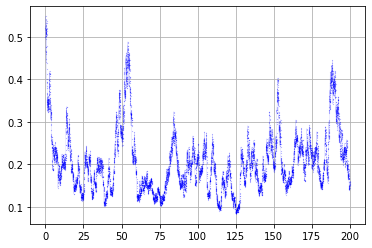

In [4]:
plt.figure()
plt.plot(sol.t,sol.y[0], 'b.--', lw=0.1, markersize=0.2)
plt.grid()
plt.show()

### Just integrate the fuck out of it

In [5]:
%%time

# Integrator 2
t = np.linspace(0,tf,N)
y = np.empty(N)

y[0] = X0
for i in np.arange(1,N):
    y[i] = y[i-1] + dt*(theta*(mu-y[i-1]) + sigma*y[i-1]*np.random.randn()/np.sqrt(dt))

CPU times: user 30 ms, sys: 993 µs, total: 31 ms
Wall time: 30.2 ms


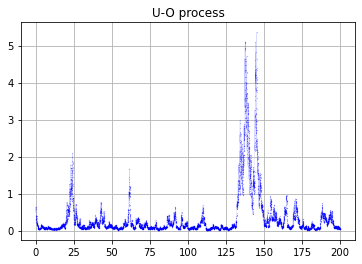

In [6]:
plt.figure()
plt.title('U-O process')
plt.plot(t,y, 'b.--', lw=0.1, markersize=0.2)
#plt.ylim([0,3])
plt.grid()
plt.show()

### Compare distributions

<ipython-input-7-9df2e7904adf>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bins = np.int(y.size**0.5/1.5) #bins='auto'
<ipython-input-7-9df2e7904adf>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.2

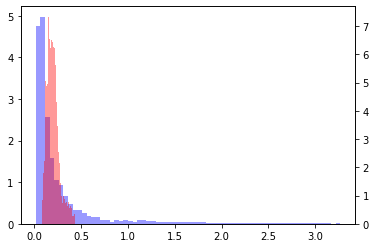

In [7]:
bins = np.int(y.size**0.5/1.5) #bins='auto'
rang = (np.percentile(y,0), np.percentile(y,99))

fig, ax = plt.subplots()

ax.hist(y, density=True, color='b', alpha=0.4, bins=bins, range=rang)


ax2 = ax.twinx()
y2 = sol.y[0]

bins = np.int(y2.size**0.5/1.5) #bins='auto'
rang = (np.percentile(y2,0), np.percentile(y2,99))


plt.hist(y2, density=True, color='r', alpha=0.4, bins=bins, range=rang)



plt.show()

## Statistical analysis of the generated curve

### Plot distribution and fit psd curve

In [8]:
bins = np.int(y.size**0.5/2) #bins='auto'
rang = (np.percentile(y,0), np.percentile(y,99))

p, x = np.histogram(y, density=True, bins=bins, range=rang) #bins='sqrt')
x = (x + np.roll(x, -1))[:-1] / 2.0

<ipython-input-8-7ed976a91696>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bins = np.int(y.size**0.5/2) #bins='auto'


popt: 
[0.1961064  0.65609088]
pcov: 
[0.02685447 0.07444965]
sig_est: (método chusco)
2.1928083131124665


<timed exec>:10: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>:10: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:10: RuntimeWarning: invalid value encountered in true_divide


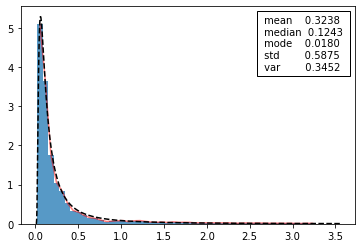

CPU times: user 153 ms, sys: 6.54 ms, total: 159 ms
Wall time: 157 ms


In [9]:
%%time

plt.figure()

plt.hist(y, density=True, alpha=0.75, bins=bins, range=rang)
plt.plot(x,p,'r-', alpha=0.5)

anchored_text = AnchoredText(" mean    {:.4f} \n median  {:.4f} \n mode    {:.4f} \n std        {:.4f} \n var        {:.4f}".format(np.mean(y), np.median(y), sp.stats.mode(y)[0][0], np.std(y), np.var(y)), loc='upper right')
plt.gca().add_artist(anchored_text)


pdf = lambda x,l,mu: (l*mu)**(1+l)/sp.special.gamma(1+l)*np.exp(-l*mu/x)/x**(l+2)

try:
    popt, pcov = sp.optimize.curve_fit(f=pdf, xdata=x, ydata=p)
    x_c = np.linspace(0,1.1*np.max(x),1000)
    plt.plot(x_c,pdf(x_c,*popt), 'k--')
    
    print('popt: ')
    print(popt)
    print('pcov: ')
    print(np.sqrt(np.diag(pcov)))
    
    l_est, mu_est = popt
    eps = 0.05*mu_est
    idx = np.abs(y-mu_est) < eps

    dy = y[1:]-y[:-1]
    sig_est = 1/(np.std(dy[idx[:-1]])/np.sqrt(dt))
    print('sig_est: (método chusco)')
    print(sig_est)

except Exception as e:
    print('Some error fitting:')
    print(e)
    
plt.show()

### Extraction of sigma

In [10]:
dy = y[1:]-y[:-1]
sigma_est = (np.mean(dy**2/y[:-1]**2))**0.5/np.sqrt(dt)
sigma_est

0.8034059373283648

#### Fit data to distribution with MLE

/Users/juan/miniconda3/envs/mutis/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1790: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


fit: 
(0.29244336919814273, 0.4427953347456376, 0, 1)


<timed exec>:10: RuntimeWarning: divide by zero encountered in true_divide
<timed exec>:10: RuntimeWarning: invalid value encountered in true_divide


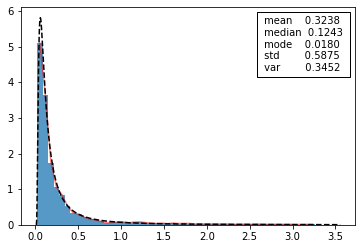

CPU times: user 39.7 s, sys: 273 ms, total: 40 s
Wall time: 39.9 s


In [11]:
%%time

plt.figure()

plt.hist(y, density=True, alpha=0.75, bins=bins, range=rang)
plt.plot(x,p,'r-', alpha=0.5)

anchored_text = AnchoredText(" mean    {:.4f} \n median  {:.4f} \n mode    {:.4f} \n std        {:.4f} \n var        {:.4f}".format(np.mean(y), np.median(y), sp.stats.mode(y)[0][0], np.std(y), np.var(y)), loc='upper right')
plt.gca().add_artist(anchored_text)


class OU(sp.stats.rv_continuous):
    def _pdf(self,x,l,mu):
        return (l*mu)**(1+l)/sp.special.gamma(1+l)*np.exp(-l*mu/x)/x**(l+2)
try:
    fit = OU(a=0.00001, b=100*np.percentile(y,100)).fit(y,1,1, floc=0, fscale=1)
    
    print('fit: ')
    print(fit)

    x_c = np.linspace(0,1.1*np.max(x),1000)
    plt.plot(x_c,pdf(x_c, fit[0],fit[1]), 'k--')
except Exception as e:
    print('Some error fitting:')
    print(e)
    
plt.show()

In [12]:
fit[0]*sigma_est**2/2

0.09438040940483189

### PSD analysis

In [13]:
def curvestats(x):
     return pd.DataFrame({'mean':np.mean(x), 'median':np.median(x), 'mode':sp.stats.mode(x)[0][0], 'gmean':sp.stats.gmean(x), 
                          'std':np.std(x), 'var':np.var(x), 
                          'mM/2':(np.amin(y)+np.amax(y))/2,
                          '0.95mM/2':(np.percentile(x,5)+np.percentile(x,95))/2}, index=[0])

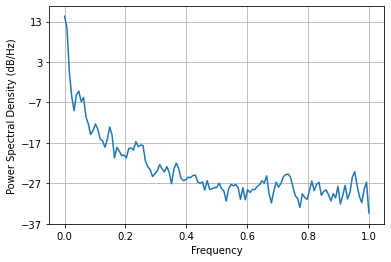

In [14]:
sig = y
t = t

plt.figure()

plt.psd(sig.real)

plt.show()

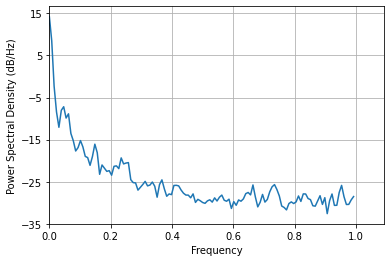

In [15]:
plt.figure()

fft = np.fft.fft(sig);
fftp = fft+3*np.random.randn(fft.size);
sigp = np.fft.ifft(fftp);


plt.psd(sigp)
plt.xlim([0,plt.gca().get_xlim()[-1]])

plt.show()

In [16]:
sig = y


f, Pxx = sp.signal.welch(sig)
#fft2 = np.sqrt(2*Pxx*Pxx.size)*np.exp(1j*2*pi*np.random.randn(Pxx.size))
fft2 = np.sqrt(2*Pxx*Pxx.size)*np.exp(1j*2*pi*np.random.random(Pxx.size))
sig2 = np.fft.irfft(fft2, n=sig.size)
a = (sig.std()/sig2.std())
b = sig.mean()-a*sig2.mean()
sig2 = a*sig2+b


fftpp = fft
sigpp = sig2

popt:
[1.83241970e+00 3.89118154e-04 1.03740256e-02]
pcov:
[0.07626832 0.0001406  0.01049175]


<ipython-input-17-61c694d9910f>:20: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(f,a/f**b+c,'r.--', lw=0.5, markersize=3, alpha=0.8)


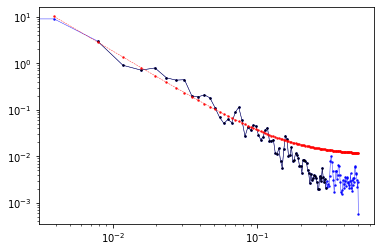

In [17]:
plt.figure()

plt.plot(f,Pxx, 'b.-', lw=0.5, markersize=3, alpha=0.8)
plt.xscale('log')
plt.yscale('log')

S = lambda w,b,a,c: a/w**b+c
msk = np.logical_and(0.005 < f,  f < 0.3)
popt, pcov = sp.optimize.curve_fit(f=S,xdata=f[msk],ydata=Pxx[msk],p0=(1.0,1,0))

print('popt:')
print(popt)

print('pcov:')
print(np.sqrt(np.diag(pcov)))

b, a, c = popt

plt.plot(f[msk],Pxx[msk], 'k.-', lw=0.5, markersize=3, alpha=0.8)
plt.plot(f,a/f**b+c,'r.--', lw=0.5, markersize=3, alpha=0.8)

plt.show()